🧩 1. Physical Activity vs Sleep Quality

Hypothesis:

Participants who accumulate more daily active minutes (especially “very active” minutes) tend to sleep longer.

Data Needed:

dailyActivity_merged.csv → VeryActiveMinutes, FairlyActiveMinutes, TotalSteps

sleepDay_merged.csv or daily aggregation from minuteSleep_merged.csv → TotalMinutesAsleep

Test:

Compute correlation or regression: SleepHours ~ VeryActiveMinutes

Optional grouping: Compare top 25% vs bottom 25% active individuals via t-test.

### 🧱 Step 1 — Setup & Imports

In [1]:
import pandas as pd
from pathlib import Path

data_folder = Path("data")

# Two periods in the Fitbit dataset
periods = [
    ("3.12.16-4.11.16", "Fitabase Data 3.12.16-4.11.16"),
    ("4.12.16-5.12.16", "Fitabase Data 4.12.16-5.12.16")
]

### 📂 Step 2 — Load & Combine Relevant Files

I need:

* `dailyActivity_merged.csv` (for active minutes)
* `minuteSleep_merged.csv` (to build daily sleep totals, since `sleepDay_merged.csv` is incomplete for period 1)

In [2]:
def load_fitbit(file_name):
    dfs = []
    for period, folder in periods:
        path = data_folder / f"mturkfitbit_export_{period}" / folder / file_name
        if path.exists():
            df = pd.read_csv(path)
            df["Period"] = period
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

activity_df = load_fitbit("dailyActivity_merged.csv")
sleep_minutes_df = load_fitbit("minuteSleep_merged.csv")

### 🧮 Step 3 — Prepare Daily Sleep Totals

Aggregate minute-level sleep into **daily totals (minutes asleep per Id per date)**.

In [5]:
# Convert date column to datetime
sleep_minutes_df["date"] = pd.to_datetime(sleep_minutes_df["date"])

# Create a helper column for just the calendar day
sleep_minutes_df["Day"] = sleep_minutes_df["date"].dt.date

# Group by Id and Day to compute total minutes asleep per day
daily_sleep = (
    sleep_minutes_df.groupby(["Id", "Day"], as_index=False)
    .agg({"value": "sum"})
    .rename(columns={"value": "TotalMinutesAsleep", "Day": "Date"})
)

print("Daily sleep shape:", daily_sleep.shape)
daily_sleep.head()


Daily sleep shape: (901, 3)


,Id,Date,TotalMinutesAsleep
0,1503960366,2016-03-13,441
1,1503960366,2016-03-14,423
2,1503960366,2016-03-15,365
3,1503960366,2016-03-16,404
4,1503960366,2016-03-17,473


### 🏃 Step 4 — Prepare Daily Activity

In [6]:
activity_df["ActivityDate"] = pd.to_datetime(activity_df["ActivityDate"], errors="coerce")

daily_activity = activity_df[[
    "Id", "ActivityDate", "VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes", "TotalSteps"
]].rename(columns={"ActivityDate": "Date"})

### 🔗 Step 5 — Merge & Compute Correlation

Join on `Id` + `Date` to align daily records, then test correlation.

In [8]:
# --- Ensure both sides use the same datetime type ---
daily_activity["Date"] = pd.to_datetime(daily_activity["Date"], errors="coerce")
daily_sleep["Date"] = pd.to_datetime(daily_sleep["Date"], errors="coerce")

# --- Merge on Id + Date ---
merged = pd.merge(daily_activity, daily_sleep, on=["Id", "Date"], how="inner")

# --- Compute sleep in hours ---
merged["SleepHours"] = merged["TotalMinutesAsleep"] / 60

# --- Quick diagnostic ---
print("Merged shape:", merged.shape)
print(merged[["Id", "Date", "VeryActiveMinutes", "SleepHours"]].head())

# --- Correlation ---
corr = merged[["VeryActiveMinutes", "SleepHours"]].corr().iloc[0, 1]
print(f"Correlation between VeryActiveMinutes and SleepHours: {corr:.3f}")


Merged shape: (646, 8)
           Id       Date  VeryActiveMinutes  SleepHours
0  1503960366 2016-03-25                 33    7.066667
1  1503960366 2016-03-26                 89    8.516667
2  1503960366 2016-03-27                 56    8.883333
3  1503960366 2016-03-28                 39    1.350000
4  1503960366 2016-03-29                 28    6.850000
Correlation between VeryActiveMinutes and SleepHours: -0.081


### 📊 Step 6 — Visualization

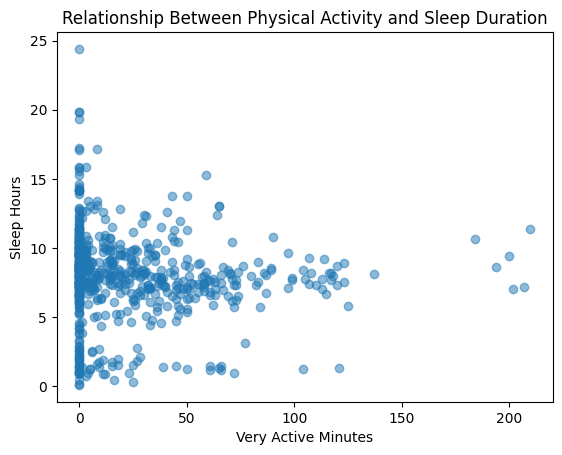

In [10]:
import matplotlib.pyplot as plt

plt.scatter(merged["VeryActiveMinutes"], merged["SleepHours"], alpha=0.5)
plt.xlabel("Very Active Minutes")
plt.ylabel("Sleep Hours")
plt.title("Relationship Between Physical Activity and Sleep Duration")
plt.show()

### 📈 Step 7 — Optional t-Test (Top vs Bottom Quartile)

In [12]:
import numpy as np, scipy.stats as stats

q25 = merged["VeryActiveMinutes"].quantile(0.25)
q75 = merged["VeryActiveMinutes"].quantile(0.75)

low = merged.loc[merged["VeryActiveMinutes"] <= q25, "SleepHours"]
high = merged.loc[merged["VeryActiveMinutes"] >= q75, "SleepHours"]

t_stat, p_val = stats.ttest_ind(high, low, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

T-statistic: -2.98, p-value: 0.0030


### 🧩 **Step 6 — The Scatterplot**

You plotted **Very Active Minutes (x-axis)** vs **Sleep Hours (y-axis)** for 646 matched day-records.

* The points are **widely scattered**, with no clear upward or downward slope.
* That matches your earlier correlation result: **–0.08**, meaning there’s basically *no strong linear link* between how active someone was that day and how long they slept that night.
* In plain words: *on a typical day, doing more intense exercise didn’t clearly make people sleep longer that same night.*

However, scatterplots can hide patterns that appear when you look at **extremes** — which is what your Step 7 t-test examined.

---

### 📈 **Step 7 — The t-Test**

You compared the **top 25 % most active days** (“high activity”) against the **bottom 25 % least active days** (“low activity”) in terms of average sleep hours.

* **T-statistic:**  –2.98
* **p-value:**  0.0030

That’s a *statistically significant* difference (p < 0.05).

Even though the correlation looked weak overall, this test tells us that the **extreme high-activity days actually had meaningfully different sleep patterns** than the least-active ones.

Because the t-statistic is **negative**, it means that **high-activity days were linked with *less* sleep**, on average, than low-activity days.

---

### 🧠 **How to Interpret This**

1. **Big picture:**
   Most days show no clear trend — everyone’s sleep bounces around a lot.
   But when you zoom in on the extremes, people who were *very active* tend to **sleep a bit less**, not more.

2. **Possible reasons:**

   * Very active days may happen on busy or long days (exercise + work + social plans).
   * Intense workouts can delay falling asleep temporarily.
   * Fitbit data noise — if someone takes their tracker off early, the device may log less “sleep time.”
   * So it might reflect **behavioral schedule differences**, not a true biological drop in sleep need.

3. **Cautions:**

   * Data covers only a few dozen people, and only about two months.
   * Sleep detection can miss naps or mislabel restless periods.
   * The p-value shows significance, but **effect size and context** matter — small but measurable.

---

### 🧾 **Summary in 9th-Grade Style**

> When we looked at everyone’s daily data, being more active didn’t really make people sleep longer — their sleep hours were all over the place.
> But when we compared the most active days to the least active ones, the very active days actually showed *less* sleep on average.
> That might mean that people who are super busy and energetic don’t always get to bed as early, or that the tracker missed part of their sleep.
> Overall, being active is good for health, but in this dataset, it didn’t automatically mean you slept more that night.


### 🧩 **Summary **

Tested whether being more physically active (measured by Fitbit “Very Active Minutes”) was linked to better sleep (longer sleep hours).

Dataset included **646 day-level records** where the same person had both activity and sleep data.

1. **Correlation (Step 5–6):**

   * Correlation = **–0.08**, essentially zero.
   * That means there was **no strong linear relationship** between activity and sleep on the same day.
   * In other words, doing more intense activity didn’t predict longer or shorter sleep in a clear straight-line way.

2. **T-Test (Step 7):**

   * Compared the **top 25 % most active days** vs. the **bottom 25 % least active days**.
   * **T = –2.98**, **p = 0.003 (< 0.05)** → statistically significant difference.
   * The negative t-value shows that the **high-activity days actually had *less* sleep** on average.

---

### 🧠 **Interpreting the Results**

* **Most days:** No clear trend — people’s sleep varied a lot for reasons unrelated to exercise.
* **Extreme days:** Very active days tended to come with *slightly shorter* sleep.

Why this might happen:

* Busy schedules — exercise, work, social time all packed in the same days.
* Hard workouts may delay falling asleep briefly.
* Fitbit gaps (taking the tracker off early) could make sleep appear shorter.
* So this is more about **daily routines and data gaps** than biology.

---

### ⚠️ **Limitations**

* Only a few dozen participants, over two months.
* Fitbit sleep tracking isn’t perfect — it can miss naps or underestimate light sleep.
* Not every participant wore the device all day/night.
* The analysis was done *per day*; weekly averages might smooth out random noise.

---

### 🧾 **Conclusion (9th-Grade-Friendly Summary)**

> When we checked everyone’s daily data, being more active didn’t clearly make people sleep longer — the amount of sleep was all over the place.
> But when we looked only at the most and least active days, the super-active ones actually had *less* sleep.
> That could mean people who do a lot during the day don’t always get to bed early, or the tracker didn’t record all their sleep.
> So, being active is great for your health, but in this dataset it didn’t automatically lead to longer sleep that night.

